In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import mpl_functions
import odor_stat_calculations as osc

import pandas as pd
import numpy as np

import scipy
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis
from scipy.stats import ks_2samp
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.formula.api as smf
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from joblib import load, dump

In [2]:
def linear_decay(distance, max_distance=2):
    # Linearly decreases from 1 to 0 where distance equals max_distance
    return max(0, (max_distance - distance) / max_distance)

def apply_boxcox(data):
    data_min = np.min(data)
    shift = 0 
    if data_min <= 0:
        shift = np.abs(data_min) + 0.5
        data_shifted = data + shift
    else:
        data_shifted = data

    transformed_data, lambda_ = scipy.stats.boxcox(data_shifted)

    return transformed_data, lambda_, shift

def get_weighted_average(x_bin, y_bin, grid_stats, max_distance=2):
    weights_sum = 0
    weighted_sum = 0
    for dx in range(-max_distance, max_distance + 1):
        for dy in range(-max_distance, max_distance + 1):
            neighbor_x, neighbor_y = x_bin + dx, y_bin + dy
            if (neighbor_x, neighbor_y) in grid_stats:
                distance = np.sqrt(dx**2 + dy**2)
                weight = linear_decay(distance, max_distance)
                neighbor_mean, _ = grid_stats[(neighbor_x, neighbor_y)]
                weights_sum += weight
                weighted_sum += weight * neighbor_mean
    if weights_sum > 0:
        return weighted_sum / weights_sum
    else:
        return np.nan  
    

def get_combined_std(means, stds, weights):    
    
    variances = [std**2 for std in stds]
    weighted_variances_sum = np.average(variances, weights=weights)
        
    combined_std = np.sqrt(weighted_variances_sum)
    
    return combined_std


def get_weighted_stats(x_bin, y_bin, grid_stats, max_distance=2):
    mean_weights_sum = 0
    variance_weights_sum = 0
    weighted_mean_sum = 0
    weighted_variance_sum = 0
    means = []
    stds = []
    weights = []

    for dx in range(-max_distance, max_distance + 1):
        for dy in range(-max_distance, max_distance + 1):
            neighbor_x, neighbor_y = x_bin + dx, y_bin + dy
            if (neighbor_x, neighbor_y) in grid_stats:
                distance = np.sqrt(dx**2 + dy**2)
                weight = linear_decay(distance, max_distance)
                neighbor_mean, neighbor_std = grid_stats[(neighbor_x, neighbor_y)]

                # Collecting weighted statistics
                weighted_mean_sum += weight * neighbor_mean
                weighted_variance_sum += weight * (neighbor_std ** 2)  # Weighted sum of variances
                mean_weights_sum += weight
                variance_weights_sum += weight 

                means.append(neighbor_mean)
                stds.append(neighbor_std)
                weights.append(weight)

    if mean_weights_sum > 0:
        weighted_mean = weighted_mean_sum / mean_weights_sum
        # Compute combined standard deviation
        weighted_std = get_combined_std(means, stds, weights)
        return weighted_mean, weighted_std
    else:
        return np.nan, np.nan  

In [3]:
test_file_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/diag17.h5"
df = pd.read_hdf(test_file_path)
query = 'odor>0'
test_df =df.query(query)
test_df=test_df.reset_index(drop=True)

Text(0, 0.5, 'Nearest From Streakline')

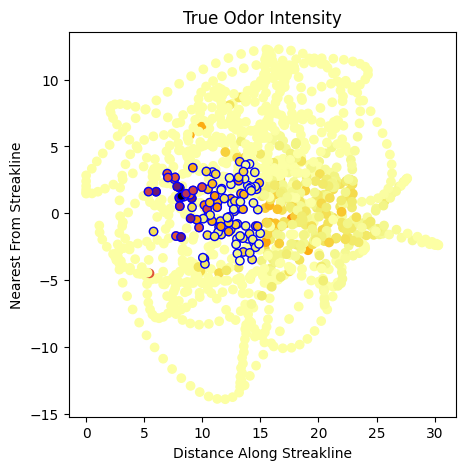

In [31]:
x_min, x_max = 5, 15  # Bounds for 'Distance Along Streakline'
y_min, y_max = -4, 4   # Bounds for 'Nearest From Streakline'


region_df = test_df[(test_df['distance_along_streakline'] >= x_min) & (test_df['distance_along_streakline'] <= x_max) &
                    (test_df['nearest_from_streakline'] >= y_min) & (test_df['nearest_from_streakline'] <= y_max)]


f,ax= plt.subplots(1,1,figsize=(5,5))

ax.scatter(df['distance_along_streakline'], df['nearest_from_streakline'], c=df['odor'],
            cmap='inferno_r', label='All Data')


ax.scatter(region_df['distance_along_streakline'], region_df['nearest_from_streakline'], c=region_df['odor'],
            cmap='inferno_r', edgecolor='blue', linewidth=1, label='Extracted Region')

ax.set_title('True Odor Intensity')
ax.set_xlabel('Distance Along Streakline')
ax.set_ylabel('Nearest From Streakline')

In [34]:
region_df=region_df.reset_index(drop=True)

In [46]:
n_bins_x = 3
n_bins_y = 3
x_bin_edges = np.linspace(x_min, x_max, n_bins_x + 1)
y_bin_edges = np.linspace(y_min, y_max, n_bins_y + 1)

# Assign data points to bins
region_df['x_bin'] = pd.cut(region_df['distance_along_streakline'], bins=x_bin_edges, labels=range(n_bins_x), include_lowest=True)
region_df['y_bin'] = pd.cut(region_df['nearest_from_streakline'], bins=y_bin_edges, labels=range(n_bins_y), include_lowest=True)

# Initialize a dictionary to store the stats for each grid cell
grid_stats = {}
region_df['odor_transformed'], lambda_1, shift1 = apply_boxcox(region_df['odor'])

# Calculate mean and standard deviation for each bin in the grid
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = region_df[(region_df['x_bin'] == i) & (region_df['y_bin'] == j)]['odor_transformed']
        if not grid_data.empty:
            grid_mean = grid_data.mean()
            grid_std = grid_data.std()
            grid_stats[(i, j)] = (grid_mean, grid_std)

# Predict using the grid stats
predictions = []
for index, row in region_df.iterrows():
    x_bin, y_bin = row['x_bin'], row['y_bin']
    if (x_bin, y_bin) in grid_stats:
        mean, _ = grid_stats[(x_bin, y_bin)]
        predictions.append(mean)
    else:
        predictions.append(np.nan)  # Append NaN for any data points that don't fit in any bin

# Convert predictions to a numpy array
predictions = np.array(predictions)

# True values
y_true = region_df['odor'].values

# Filter out NaN predictions
valid_indices = ~np.isnan(predictions)
y_pred = predictions[valid_indices]
y_true_valid = y_true[valid_indices]

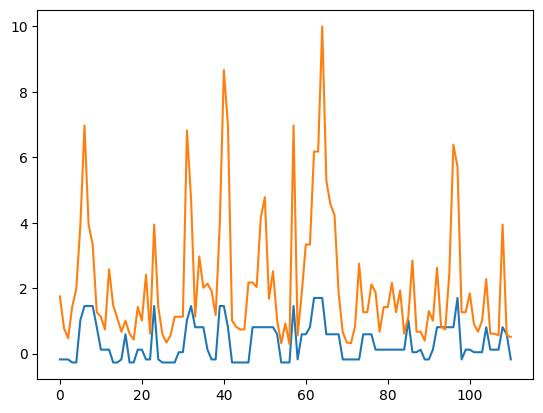

In [47]:
plt.plot(predictions)
plt.plot(region_df.odor)

In [48]:
if shift != 0:
    predictions_original = scipy.special.inv_boxcox(predictions, lambda_1) - shift1
else:
    predictions_original = scipy.special.inv_boxcox(predictions, lambda_1)

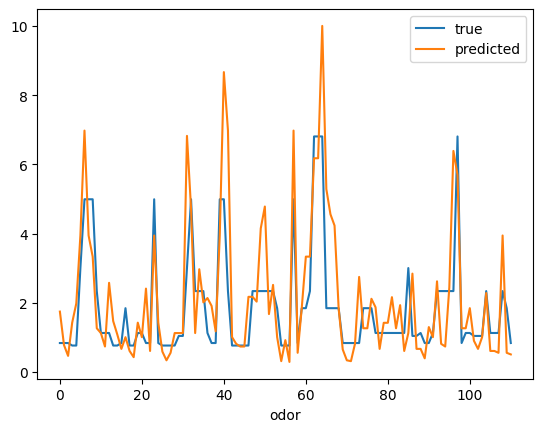

In [55]:
plt.plot(predictions_original, label='true')
plt.plot(region_df.odor, label='predicted')
plt.xlabel('odor')
plt.legend()

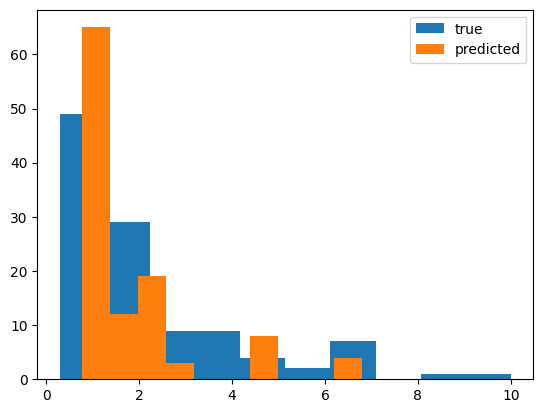

In [57]:
plt.hist(region_df.odor, label='true')
plt.hist(predictions_original, label='predicted')
plt.legend()

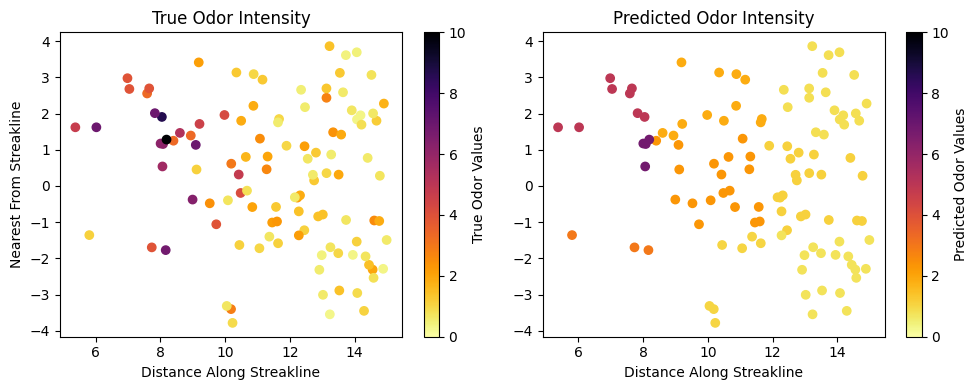

In [54]:
# Replace NaN predictions with zeros (or another value)
predictions_filled = np.nan_to_num(predictions_original, nan=0)  # Replace NaNs with 0

# There's no need to filter out NaN values since you've replaced them
x_pred_filled = region_df['distance_along_streakline'].values
y_pred_filled = region_df['nearest_from_streakline'].values

y_true_filled = np.nan_to_num(y_true, nan=0)  # Replace NaNs with 0, if applicable

# Now plot using the filled arrays
f, axes = plt.subplots(1, 2, figsize=(10, 4))

# True Odor Values
sc1 = axes[0].scatter(region_df['distance_along_streakline'], region_df['nearest_from_streakline'], 
                      c=region_df.odor, 
                      cmap='inferno_r', vmin=0, vmax=10)
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Intensity')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

# Predicted Odor Values
sc2 = axes[1].scatter(region_df['distance_along_streakline'], region_df['nearest_from_streakline'], 
                      c=predictions_original, 
                      cmap='inferno_r', vmin=0, vmax=10)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Intensity')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()
